# Main Guide

**Author**: Clarence Mah | **Last Updated**: {sub-ref}`today`

Here we will analyze a subset of the U2-OS cell dataset from the Bento paper, in which 130 genes and 5 non-targeting controls are spatially profiled with MERFISH. The full dataset includes 1153 cells, each with cell/nuclear segmentation masks and 2D transcript coordinates. Here we demonstrate Bento's key functionality on a representative subset.


## Setup

Load libraries used in this analysis.


In [1]:
import bento as bt
import matplotlib.pyplot as plt

## Load Data

Download the MERFISH dataset from the Bento paper [at this link](https://huggingface.co/datasets/ckmah/mah2024_merfish/resolve/main/merfish_u2os.zip) and unzip it to a folder named `merfish_u2os.zarr`.

The loaded object is a `SpatialData` object, a container for spatial omics data. Under the hood, the [`SpatialData`](https://spatialdata.scverse.org/en/latest/) framework reads/writes data from/to disk and provides a unified interface in Python.

```{note}
See [Data Format](../howitworks.md) for more details.
```


In [2]:
sdata = bt.ds.sample_data()
sdata

Indexing shapes...
Aggregating counts...
Done.


SpatialData object with:
├── Points
│     └── 'transcripts': DataFrame with shape: (221090, 6) (2D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (15, 3) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (15, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 15 × 135
    obs: 'cell_boundaries', 'region'
    uns: 'spatialdata_attrs': AnnData (15, 135)
with coordinate systems:
▸ 'global', with elements:
        transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (Shapes)

## Visualize Data

Let's visualize the data to gain a better intuition for the dataset. Spatial plotting functions in `bento-tools` automatically render cell and nuclear boundaries by default. We then overlay the transcript density on top with `bt.pl.density()`.

```{tip}
See the [spatial plotting guide](Spatial_Plotting) for more details.
```


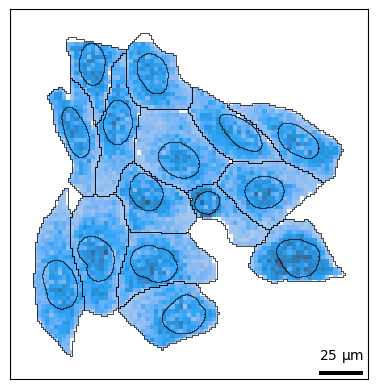

In [3]:
bt.pl.density(sdata)

We can visualize individual molecules with `bt.pl.points()`.

```{tip}
Plotting many genes can be slow; if all you need is a visual overview, set `legend=False` and the plot should render faster.
```


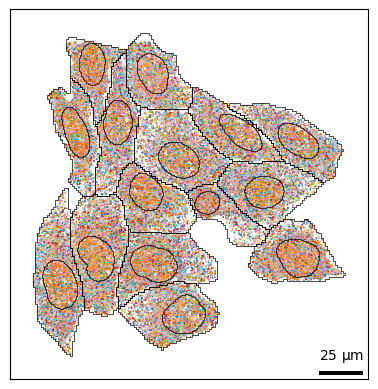

In [4]:
bt.pl.points(
    sdata,
    hue="feature_name",
    legend=False,
    s=1,
    palette="tab20",
)

Keep genes where at least 10 molecules are detected in at least one cell.


In [5]:
sdata = bt.geo.filter_by_gene(sdata, threshold=10)

## Spatial summary statistics

You can get a quick summary of cell and nuclear properties, including area, shape i.e. aspect ratio, and RNA density. This is an easy way to assess data quality and manage outliers e.g. cells with an extreme number of transcripts, very small area (possibly segmentation artifacts), no nuclei, etc.

```{seealso}
See the [spatial features tutorial](Spatial_Features) for additional metrics.
```


In [6]:
bt.tl.shape_stats(sdata)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 112.93it/s]


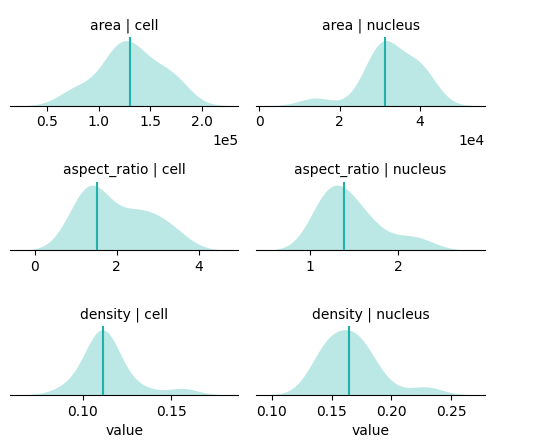

In [7]:
bt.pl.shape_stats(sdata)

## RNAflux: semantic segmentation of subcellular domains

RNAflux first quantifies subcellular expression gradients at pixel resolution before identifying consistent subcellular domains via unsupervised clustering. The result is a semantic segmentation of the cell, where each pixel is assigned to a subcellular domain. For the purposes of this tutorial, we will lower the resolution `res` parameter to speed up computation.

```{tip}
The embedding is calculated at 10% unit resolution for speed. Higher resolution trades off speed for smoother embeddings. Note that computation time scales quadratically $O(res^{2})$ in relation to resolution $res$ e.g. 10% is 100x faster than 100% resolution.

Learn more about [the algorithm here](../howitworks.md).
```

In [8]:
res = 0.1
bt.tl.flux(sdata, res=res)

Done. 🍱: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.81it/s]


`bt.tl.flux()` also performs dimensional reduction using PCA and saves the first 10 principal components (PCs). We can visualize each pixel as the first 3 PCs mapped to RGB values (red = PC1, green = PC2, and blue = PC3) and scale alpha by the RNA density.


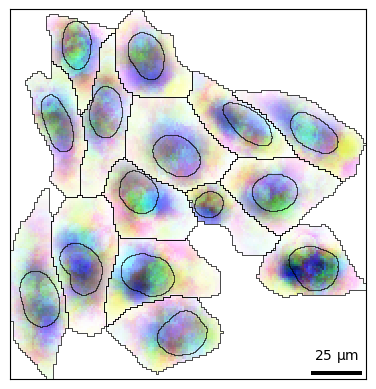

In [10]:
bt.pl.flux(sdata, res=res)

### Identify subcellular domains

To identify distinct subcellular domains in a data-driven manner, we can cluster pixels by their RNAflux embeddings. The `bt.tl.fluxmap()` function fits a self-organizing map (SOM) to the reduced PCA space for a range of cluster numbers. We use the [elbow method heuristic](<https://en.wikipedia.org/wiki/Elbow_method_(clustering)>) to recommend the optimal number of clusters. By default, a line plot will be rendered showing the model fit error for each cluster number and draw a vertical dotted line indicating the recommended number.

```{tip}

Determining the number of clusters is not trivial and can be highly subjective. Occasionally, no number is suggested. You can either try a wider range of cluster numbers or manually pick one. We generally recommend settling on a smaller number of clusters i.e. less than 10 for interpretability.
```


 71%|█████████████████████████████████████████████████████████████████████████████████▍                                | 5/7 [00:00<00:00, 42.22it/s]
                                                                                                                                                     

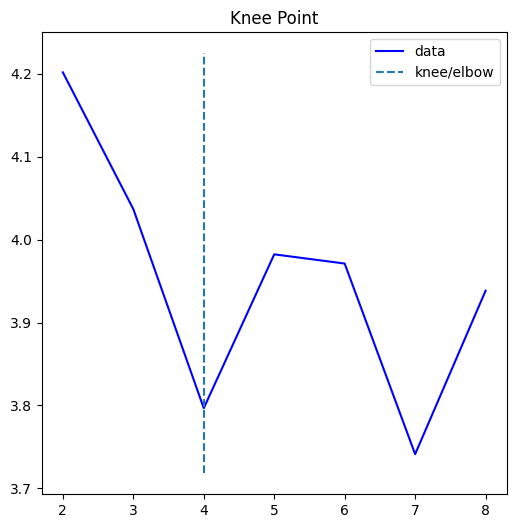

Done: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s]


In [11]:
bt.tl.fluxmap(sdata, res=res)

Now let's visualize the predicted subcellular domains. Notice how every cell contains instances of each domain (denoted by the different colors).


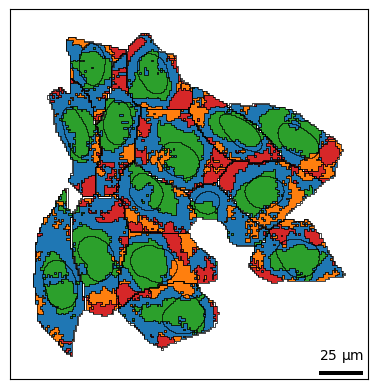

In [12]:
bt.pl.fluxmap(sdata)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Adjusting text positions...


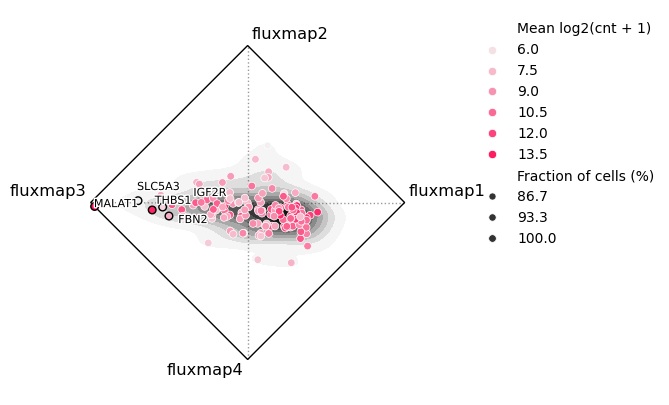

In [13]:
bt.tl.comp(
    sdata,
    points_key="transcripts",
    shape_names=["fluxmap1", "fluxmap2", "fluxmap3", "fluxmap4"],
)
bt.pl.comp(sdata, annotate=5)

### Functional enrichment of fluxmaps

We can utilize RNAflux embeddings to compute enrichment scores across the entire area of each cell. Given the appropriate genesets, they can help us identify functionally relevant domains such as organelles and subcellular compartments e.g. the nucleus and cytoplasm. Here we employ published [APEX-seq data](https://doi.org/10.1016/j.cell.2019.05.027) measuring the relative expression (log2 fold change) of genes in various compartments. We can compare geneset enrichment scores to the fluxmaps.


In [14]:
bt.tl.fe_fazal2019(sdata)

Running wsum on mat with 19327 samples and 133 targets for 8 sources.
Infering activities on 2 batches.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


You can visualize functional enrichment scores with `bt.pl.fe()` as well as specific shapes to overlay. In this case, we showcase the striking correspondence of the "Nucleus" enrichment with one of the fluxmaps.


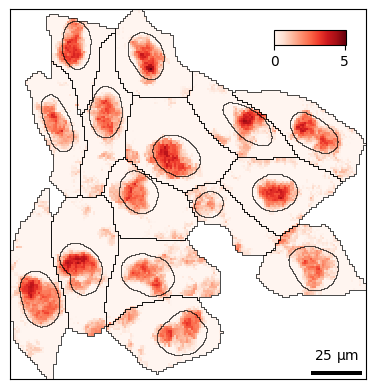

In [15]:
bt.pl.fe(
    sdata,
    "flux_Nucleus",
    cmap="Reds",
    res=res,
    vmin=0,
)

## Predict RNA Localization Patterns

We will use the RNAforest model, to predict and annotate subcellular localization patterns. A single "sample" refers to the set of points corresponding to a given gene in a single cell. In the case that every cell expresses every gene, the number of samples is at most $n * m$ for $n$ cells and $m$ genes.

<img src="../_static/tutorial_img/rnaforest_workflow.png" alt="RNA Localization Pattern Annotation Workflow" width="800">

The five subcellular patterns we can predict are:

1. **cell edge**: near the cell membrane
2. **cytoplasmic**: mostly outside the nucleus in the cytoplasm
3. **nuclear**: most in the nucleus
4. **nuclear edge**: near the nuclear membrane, either
5. **none**: none of the above patterns, more or less randomly distributed

```{seealso}
See [more details about the spatial statistics](../howitworks.md) used as input features for classification.
```


In [16]:
bt.tl.lp(sdata)

Crunching shape features...
Crunching point features...
Saving results...
Done.
Crunching shape features...
Crunching point features...
Saving results...
Done.


We can view the observed pattern frequencies to get a rough idea of how transcripts are localizing.


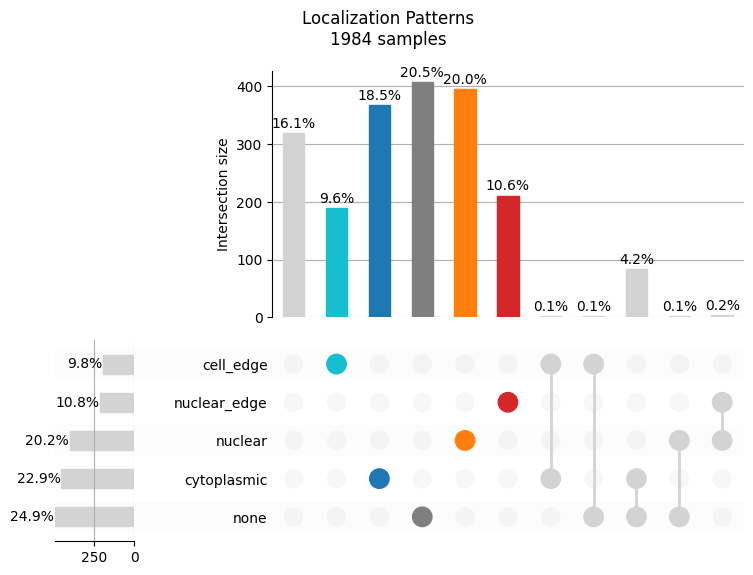

In [17]:
bt.pl.lp_dist(sdata)

We can also visualize the localization of each gene where the point position denotes the balance between subcellular localization pattern frequencies. The color denotes the gene's most frequent pattern. Interestingly, we see a wide range of variability in localization. A large number of genes are pulled towards none while nuclear enriched genes show strong bias and a high fraction of cells.


In [18]:
bt.tl.lp_stats(sdata)

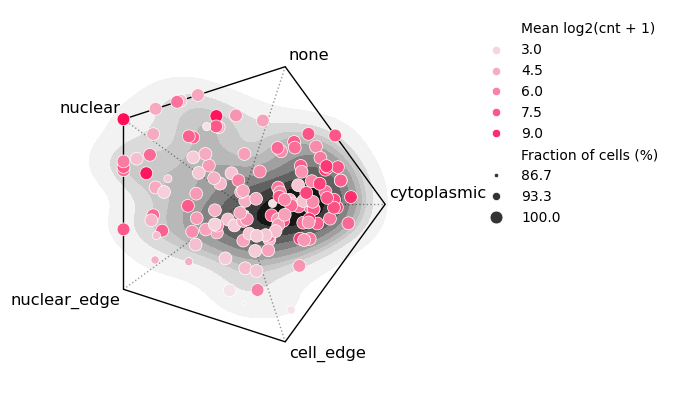

In [19]:
bt.pl.lp_genes(sdata, sizes=(10, 85), size_norm=(90, 100))

## Colocalization analysis

Here we use the Colocation Quotient or CLQ ([Leslie & Kronenfeld, 2011](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1538-4632.2011.00821.x)) to measure pairwise colocalization between genes. Given two sets of points, A and B, the CLQ is the ratio of observed to expected proprtion of B among A's neighbors.

At the same time, we quantify colocalization in a compartment-specific manner i.e. transcripts in the nucleus organize differently than they do in the cytoplasm.

<img src="../_static/tutorial_img/clq_workflow.png" alt="colocalization analysis workflow" width="800px" class="p2">


First lets create shapes for the cytoplasm.


In [20]:
bt.geo.overlay(
    sdata,
    s1="cell_boundaries",
    s2="nucleus_boundaries",
    name="cytoplasm",
    how="difference",
)

Indexing points...
Indexing shapes...
Aggregating counts...
Done.


Now we can calculate CLQ values for every gene pair -- one for the cytoplasm and once more for the nucleus.


In [21]:
bt.tl.coloc_quotient(sdata, shapes=["cytoplasm", "nucleus_boundaries"])

nucleus_boundaries: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.01it/s]


We can represent the data as a 3-dimensional tensor: compartments, cells, and gene pairs and apply tensor decomposition - in this case, non-negative PARAFAC ([Shashua & Hazan 2005](https://dl.acm.org/doi/10.1145/1102351.1102451)) - to discover substructure considering cell and compartment-specific patterns.

The data tensor is broken down into $k$ factors. When added together, the factors reconstruct the original data tensor with some degree of error. By plotting the error for each $k$ rank decomposition, we can use the [elbow method heuristic](<https://en.wikipedia.org/wiki/Elbow_method_(clustering)>) to recommend the optimal number of factors.


Preparing tensor...
:running: Decomposing tensor...


Device cuda: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]

:heavy_check_mark: Done.


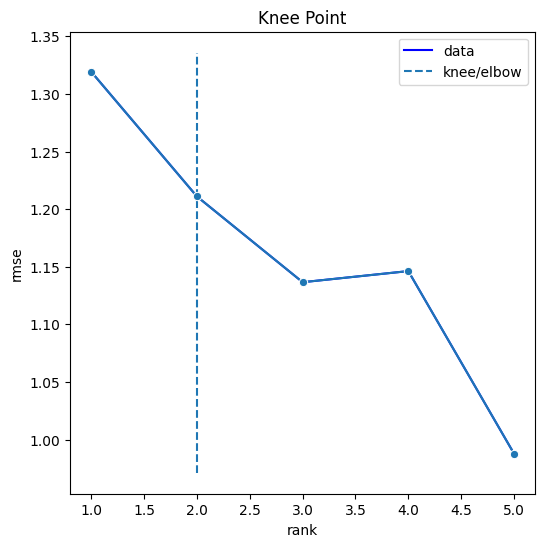

In [22]:
bt.tl.colocation(sdata, ranks=range(1, 6))

Let's plot the factor loadings for the suggested $k = 3$. From left to right, the three heatmaps show the loadings of each factor for each dimension – compartments, cells, and gene pairs. We can limit the heatmap to show the top 5 associated gene pairs for each factor.


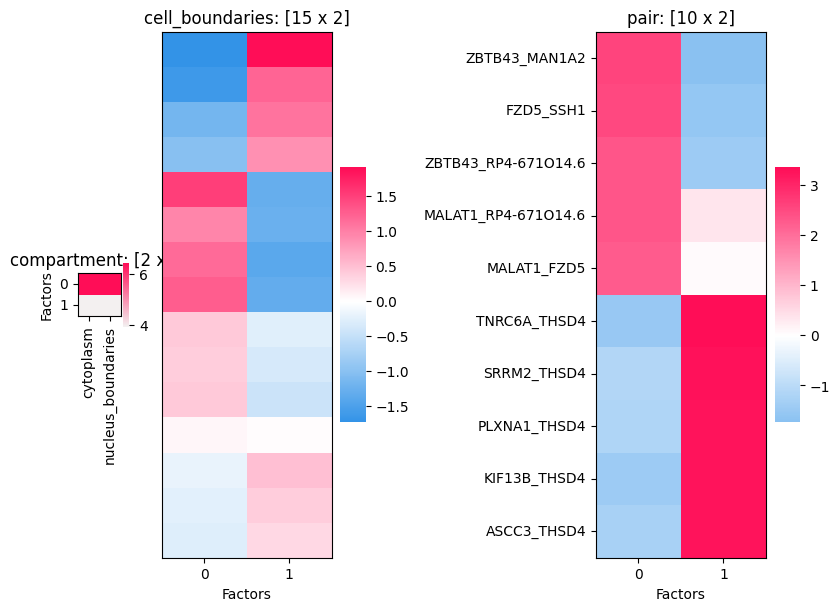

In [23]:
bt.pl.colocation(sdata, rank=2)